###### Introduction to Network Analysis 2023/24 (viii)

## Blockmodeling & stochastic block models, $k$-core decomposition

Browse [CDlib](https://cdlib.readthedocs.io/en/latest/), [NetworkX](https://networkx.org/documentation/stable/reference/algorithms/community.html), [graph-tool](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html) or other library for implementations of network community detection and graph partitioning algorithms. Select an algorithm which you will be using in the exercises below. For instance, select one of most popular algorithms such as hierarchical optimization of modularity known as Louvain algorithm, map equation algorithm called Infomap, simple label propagation algorithm, hierarchical clustering based on edge betweenness, Markov clustering algorithm, (degree-corrected) stochastic block model etc.

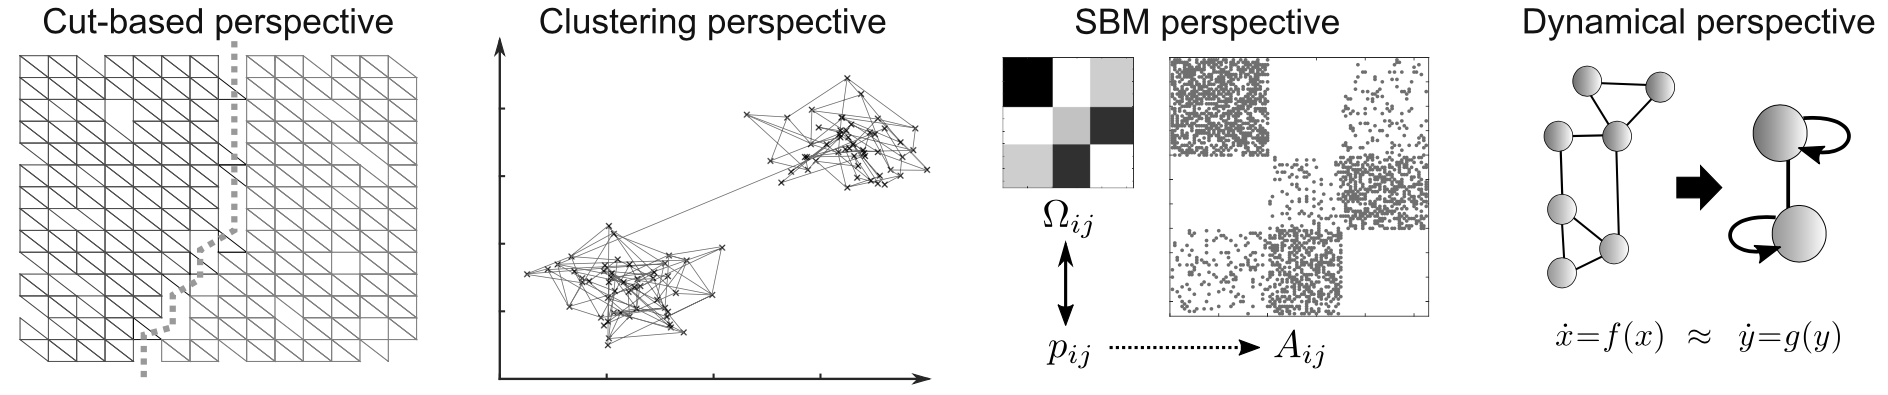

### II. Blockmodeling of Šubelj-Bajec benchmark graphs



1. **(homework)** Apply the (degree-corrected) stochastic block model to Šubelj-Bajec synthetic benchmark graphs with planted assortative and disassortative structure, and test whether the revealed clusters coincide with the planted group structure. You should apply the algorithm to graphs with varying mixing parameter $\mu$ and compare partitions using some standard measure. For which values of $\mu$ does the algorithm reveal the planted partition?

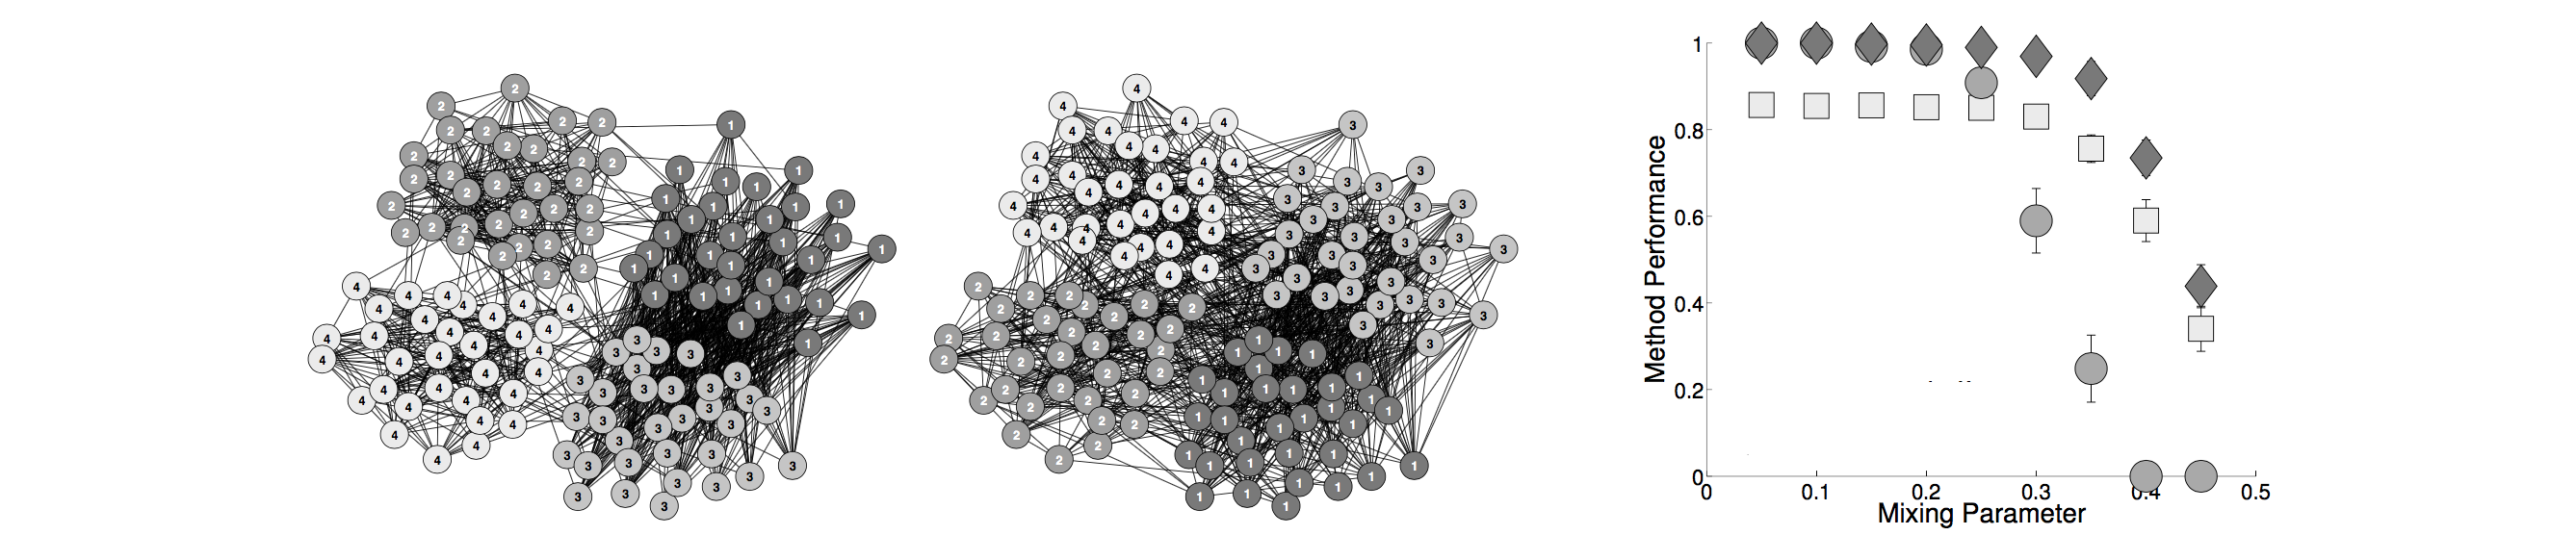

In [ ]:
import random
import numpy as np
import networkx as nx
import utils
from matplotlib import pyplot as plt


def subelj_bajec(mu = 0.1):
  G = nx.MultiGraph(name = "subelj_bajec")
  for i in range(128):
    G.add_node(i, cluster = i // 32 + 1)

  for i in range(128):
    for j in range(i + 1, 128):
      if G.nodes[i]['cluster'] <= 2 and G.nodes[j]['cluster'] <= 2:
        if G.nodes[i]['cluster'] == G.nodes[j]['cluster']:
          if random.random() < 16 * (1 - mu) / 31:
            G.add_edge(i, j)
        else:
          if random.random() < mu / 6:
            G.add_edge(i, j)
      elif G.nodes[i]['cluster'] >= 3 and G.nodes[j]['cluster'] >= 3:
        if G.nodes[i]['cluster'] != G.nodes[j]['cluster']:
          if random.random() < (1 - mu) / 2:
            G.add_edge(i, j)
        else:
          if random.random() < 16 * mu / 95:
            G.add_edge(i, j)
      elif random.random() < mu / 6:
        G.add_edge(i, j)

  return G

utils.info(sbg := subelj_bajec(), clustering_sample=len(sbg))

  MultiGraph | 'subelj_bajec'
       Nodes | 128 (iso=0)
       Edges | 1,041 (loop=0)
      Degree | 16.27 (max=24)
         LCC | 100.0% (n=1)
  Clustering | 0.2330



In [ ]:
from cdlib import algorithms
from tqdm import tqdm

# see https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/node_clustering.html
algs = {
    "Known": lambda G: utils.known_clustering(G, cluster_attr="cluster"), "Louvain": algorithms.louvain,
    "Leiden": algorithms.leiden, "LPA": algorithms.label_propagation, "FLPA": utils.fast_label_propagation,
    "DCSBM": algorithms.sbm_dl # func. etymology: Stochastic Block Model minimizing Description Length
}

runs = 100
mus = np.arange(0, 1, 0.05)

plt.figure()

# NOTE: this wasn't properly tested, as cdlib is a nightmare to install.
for alg in algs:
    NMI = [0 for _ in range(len(mus))]

    for _ in tqdm(range(runs), desc=f"testing {alg}"):
        for i, mu in enumerate(mus):
            G = subelj_bajec(mu)

            K = utils.known_clustering(G, cluster_attr="cluster")
            C = algs[alg](G)

            NMI[i] += K.normalized_mutual_information(C).score / runs

    plt.plot(mus, NMI, label=alg)

plt.xlabel("Mixing $\mu$")
plt.ylabel("NMI")
plt.legend()

plt.savefig("subelj_bajec.pdf", bbox_inches='tight')


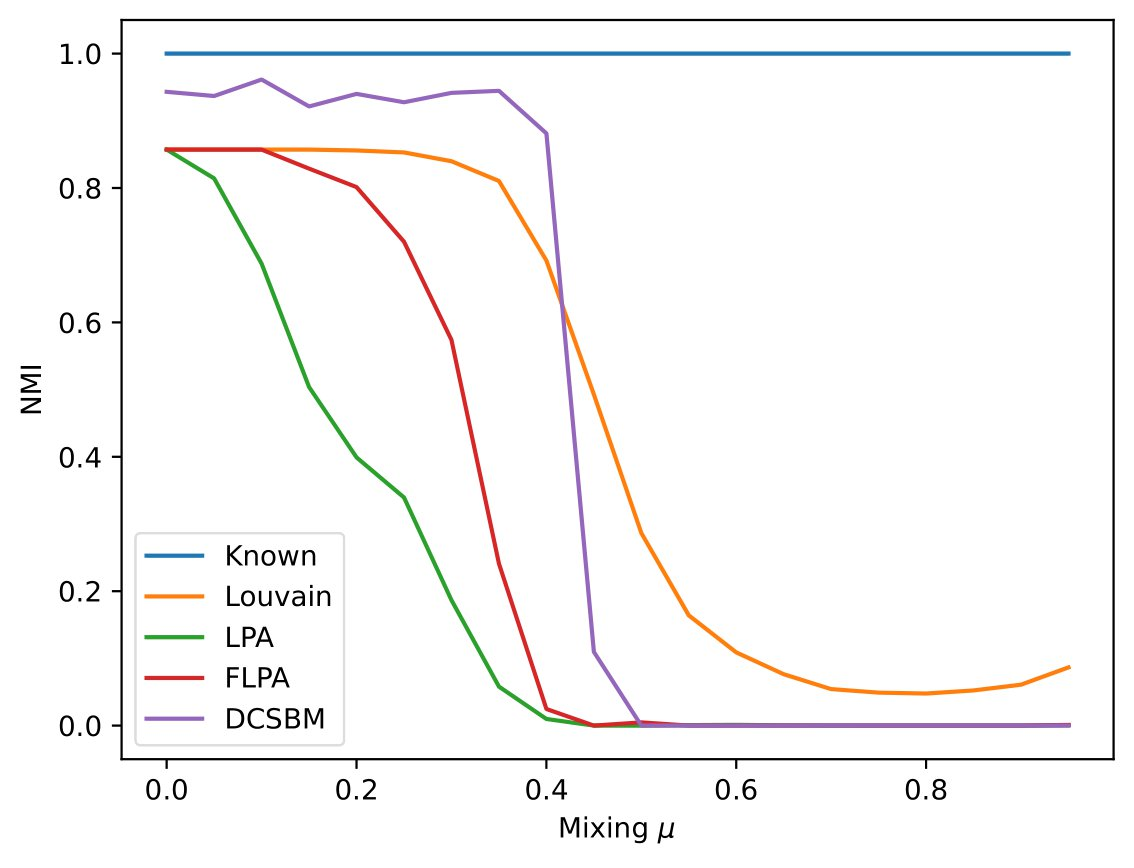

We can see that stochastic block models yield the best results, as we have a sharp dropoff in *NMI* (meaning the algorithm is "sure of itself").